## Семинар 2 "Распознавание рукописных цифр"

ФИО: 

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [3]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline

In [4]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    
    print(X.shape)
    print(y)
    break

(32, 784)
[9 1 7 9 4 2 2 2 9 2 3 0 1 5 5 4 8 7 0 2 1 6 0 1 7 8 3 2 8 9 3 3]


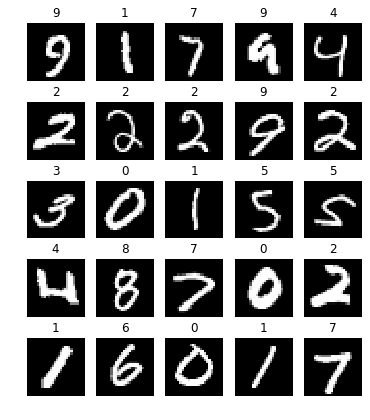

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [7]:
#activation = ReLU()
activation = Sigmoid()

inner_dim = 64

layers = [Linear(784, inner_dim), activation]
for i in range(1):
    layers.extend([Linear(inner_dim, inner_dim), activation])

layers.append(Linear(inner_dim, 10))

net = NeuralNetwork(layers)
loss = NLLLoss()

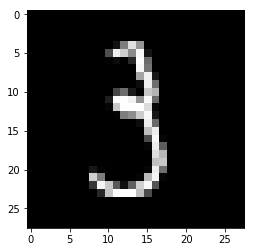

In [8]:
for X, y in train_loader:
    X = X.numpy()
    break
plt.imshow(X[0].reshape(28, 28), cmap=plt.cm.Greys_r)

In [9]:
x = net.forward(X[0].reshape(1, -1))[0]
order = np.argsort(x)[::-1]
print(order, x[order])

[8 1 3 2 5 6 0 4 9 7] [ 0.10486788  0.08766691  0.06619846  0.04070817  0.01994826  0.01888188
  0.01679238  0.00175409 -0.00567244 -0.03203123]


In [10]:
losses = []

## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    
    res = net.forward(X)
    l = loss.forward(res, y)
    
    losses.append(l)
    
    dLdy = loss.backward()
    
    net.backward(dLdy)
    net.step(0.1)

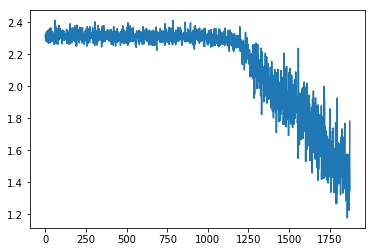

In [11]:
plt.plot(losses)
#plt.plot(sigm_losses)
#plt.plot(good_relu_losses)
plt.show()

In [12]:
good_relu_losses = losses

In [13]:
print(l)

1.781535956167706


### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [14]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = (X > 0).astype(float)*X
        return self.s
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.s > 0).astype(float)*dLdy
    
    def step(self, learning_rate):
        pass

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [15]:
errors = []

for X, y in test_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    
    res = net.forward(X)
    
    for x_i, y_i in zip(X, y):
        l = loss.forward(x_i.reshape(1, -1), y_i.reshape(1, -1))
        errors.append((l, x_i.reshape(28, 28)))
    
    if len(errors) > 1000:
        break

### HW1 (1 балл): Реализовать Tanh

In [16]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        self.Y = 2 / (1 + np.exp(-2 * X)) - 1
        return self.Y
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        tmp = 2 / (1 + np.exp(-2 * self.X))
        self.dLdx = tmp * (2 - tmp) * dLdy
        return self.dLdx
    
    def step(self, learning_rate):
        pass

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [17]:
def set_net(activation=Sigmoid()):
    inner_dim = 64
    outter_dim = 10
    layers = [Linear(784, inner_dim), activation, Linear(inner_dim, outter_dim)]
    net = NeuralNetwork(layers)
    return net

In [18]:
loss = NLLLoss()

In [19]:
from skimage.transform import rotate  

In [86]:
def rotate_(x, angle=10):
    s = int(x.flatten().shape[0] ** 0.5)
    x = x.reshape(s, s)
    return rotate(x, angle).flatten()

def noise(x):
    s = int(x.flatten().shape[0])
    x += np.random.randn(s) * 0.2
    return x

In [117]:
def learn_net(par, rot_len=10, noize_len=3, activation=Sigmoid()):
    net = set_net(activation)
    k = 0
    for X, y in train_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy() ### Converts torch.Tensor to numpy array
        y = y.numpy()
        n_changes = int(y.shape[0])
        for i in range(n_changes):
            if par in ["rotation", "all"]:
                for angle in range(-rot_len, rot_len):
                    X = np.append(X, rotate_(X[i], angle)).reshape(-1, 784)
                    y = np.append(y, y[i])
            if par in ["noize", "all"]:
                for _ in range(noize_len):
                    X = np.append(X, [noise(X[i])]).reshape(-1, 784)
                    y = np.append(y, y[i])
        res = net.forward(X)
        l = loss.forward(res, y)
        dLdy = loss.backward()
        net.backward(dLdy)
        net.step(0.1)
    return net

In [90]:
def print_loss(par, losses, num=10):
    print("Top {0} losses on tests dataset with {1}".format(num, par))
    for i in losses[-10::]:
        print(i)
    print("\n")
    print("Mean is {}".format(np.mean(losses)))
    print("Median is {}".format(np.median(losses)))
    print("\n")

Возьмем сначала функцию активации Sigmoid()

In [91]:
for par in ["nothing", "rotate", "noize"]:
    losses = []
    net = learn_net(par)
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy() ### Converts torch.Tensor to numpy array
        y = y.numpy()
        res = net.forward(X)
        l = loss.forward(res, y)
        losses.append(l)
    print_loss(par, losses)

Top 10 losses on tests dataset with nothing
0.35799224223970294
0.3294958036249086
0.09947673034484922
0.22060668840265418
0.3580702892213479
0.3394894377853395
0.14216741548744277
0.26432392319966913
0.023894269131712297
0.06686472543804166


Mean is 0.2308304466524793
Median is 0.20753722436070382


Top 10 losses on tests dataset with rotate
0.3223983509670645
0.1729396267509023
0.08794540762354186
0.045181466977489614
0.2673504012708115
0.4651140876327815
0.2556904895793757
0.1938350978326025
0.24725824853323064
0.2608211857450801


Mean is 0.2317599269818507
Median is 0.21747016345506803


Top 10 losses on tests dataset with noize
0.07465591555794437
0.1845669168425252
0.2681042833586458
0.21471276709803777
0.19199965742505493
0.19122409793266845
0.18786366046000985
0.32387260999544076
0.1981883373174412
0.5142184236201911


Mean is 0.23156161101296868
Median is 0.20736080136404844




In [121]:
for par in ["all"]:
    losses = []
    net = learn_net(par, 5)
    i = 0
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy() ### Converts torch.Tensor to numpy array
        y = y.numpy()
        res = net.forward(X)
        l = loss.forward(res, y)
        losses.append(l)
    print_loss(par, losses)

Top 10 losses on tests dataset with all
0.22975619838131614
0.10835127159743549
0.1410042852954626
0.2099160775427121
0.12201992868326403
0.35668993066140925
0.25833747322377393
0.4824764541504556
0.1686902012147896
0.2275211069987583


Mean is 0.23457427725997543
Median is 0.2229636813095128




Посмоторим какой резальтат при activation=Tanh()

In [119]:
for par in ["nothing", "rotate", "noize"]:
    losses = []
    net = learn_net(par,10,3,Tanh())
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy() ### Converts torch.Tensor to numpy array
        y = y.numpy()
        res = net.forward(X)
        l = loss.forward(res, y)
        losses.append(l)
    print_loss(par, losses)

Top 10 losses on tests dataset with nothing
0.10633376958976806
0.05431352055183951
0.20209730020690173
0.2496637065431472
0.1494578771695066
0.12966695795952246
0.12147751272742352
0.14216505337541155
0.15296706422709477
0.0764938340570352


Mean is 0.1548479709310647
Median is 0.12997745833176452


Top 10 losses on tests dataset with rotate
0.26659091791633827
0.2172328075617933
0.15155064617009978
0.16239677717737727
0.08419124644347821
0.10861544618232753
0.25540473031847444
0.13515572473910087
0.06959494722735096
0.6528475049063691


Mean is 0.1558808153278436
Median is 0.13110121565841595


Top 10 losses on tests dataset with noize
0.120005592763655
0.08639913976333592
0.05877488957551581
0.07012048747698515
0.06389777700463306
0.16995271705620102
0.13539721809375682
0.0810171187790431
0.11050855112817377
0.1215604726049628


Mean is 0.15076621734983459
Median is 0.12425913955270049




Теперь посмотри Relu()

In [123]:
for par in ["nothing", "rotate", "noize"]:
    losses = []
    net = learn_net(par,10,3,ReLU())
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy() ### Converts torch.Tensor to numpy array
        y = y.numpy()
        res = net.forward(X)
        l = loss.forward(res, y)
        losses.append(l)
    print_loss(par, losses)

Top 10 losses on tests dataset with nothing
0.1491411487176783
0.1471371068046143
0.03001863994720927
0.2015618815907188
0.05315453773150116
0.0778790445884745
0.06757905317983734
0.047163391036660895
0.019141376604799313
0.03296924154913615


Mean is 0.13494227232806927
Median is 0.10887980891345136


Top 10 losses on tests dataset with rotate
0.05329051667257807
0.0892487921046949
0.018929818583155046
0.34745479112634603
0.35959844878920316
0.1197542476744663
0.006306457625177675
0.062018027912059945
0.05041306664278953
0.02584816000329748


Mean is 0.12575970080916474
Median is 0.10345032819903832


Top 10 losses on tests dataset with noize
0.1587937605800519
0.1642210147081749
0.07765911167389825
0.07191402368469818
0.061135700450076096
0.054165612480898274
0.08419455134805658
0.04389756335271409
0.5125461502009752
0.025617975134215085


Mean is 0.14289101577754465
Median is 0.11508470911010589




Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [26]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass
    

class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

<function matplotlib.pyplot.show(*args, **kw)>

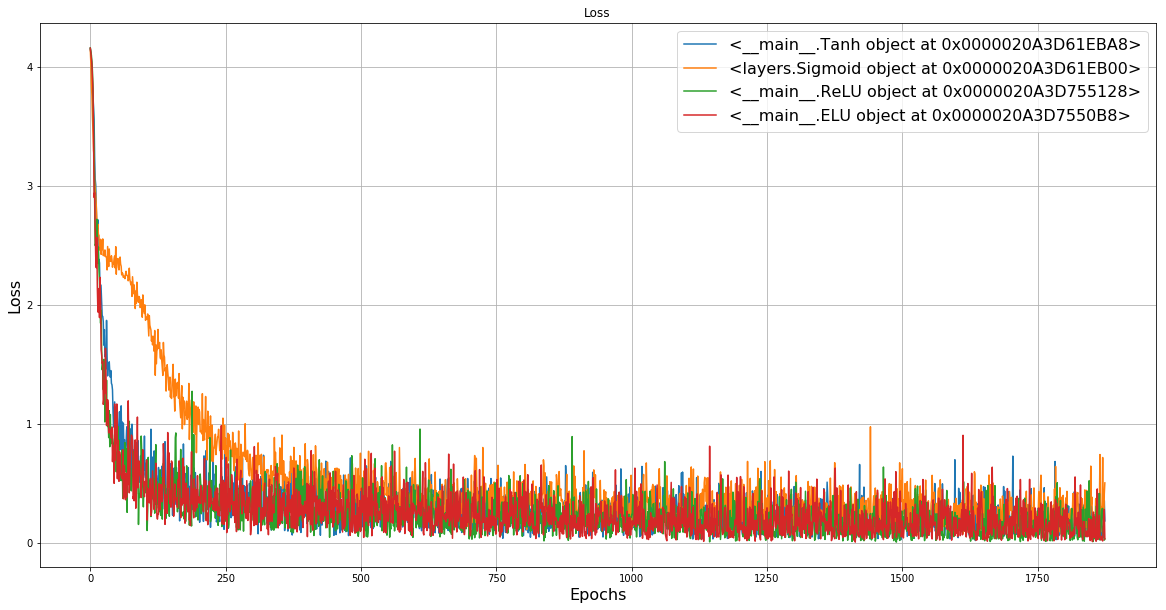

In [25]:
fig, ax = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
plt.title('Loss')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.grid()
for activation in [Tanh(), Sigmoid(), ReLU(), ELU()]:
    losses = []
    net = set_net(activation)
    for X, y in train_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy() ### Converts torch.Tensor to numpy array
        y = y.numpy()
        res = net.forward(X)
        l = loss.forward(res, y)
        losses.append(l)
        dLdy = loss.backward()
        net.backward(dLdy)
        net.step(0.1)
    plt.plot(losses, label=activation)
plt.legend(loc=0, fontsize=16)
plt.show

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Говоря о выборе нелинейности, Relu и Elu показывают одинаковый результат как на скорости сходимости, так и на Loss, Sigmoid показывает результаты хуже. Предобработка данных, получается, что не особо улучшает скорость сходимости и Loss.